In [1]:
import networkx as nx
import random
from matplotlib import pyplot as plt
from functools import wraps
import time
import os
import pandas as pd

In [2]:
df = pd.DataFrame(columns=["time", "nodes", "edges", "best_w",  "iterations", "k"])

In [3]:
def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        result1, result2 = func(*args, **kwargs)
        end = time.perf_counter()
        elapsed = end - start
        print(f"{func.__name__} took {elapsed:.6f} seconds")
        return (result1, result2, elapsed)
    return wrapper

In [4]:
def initialize(G, terminals):
    subgraph = G.subgraph(terminals)
    
    if not nx.is_connected(subgraph):
        H = nx.Graph()
    
        for u in terminals:
            for v in terminals:
                if u != v:
                    path = nx.shortest_path(G, u, v, weight = "weight")
                    nx.add_path(H, path)
        subgraph = H
    
    best_tree = nx.minimum_spanning_tree(subgraph, weight = "weight")
    best_w = best_tree.size(weight = "weight")
    best_nodes = set(best_tree.nodes())

    return best_tree, best_w, best_nodes

In [5]:
def evaluate(G, nodes):
    subgraph = G.subgraph(nodes)
    if not nx.is_connected(subgraph):
        return None, float("inf")
    T = nx.minimum_spanning_tree(subgraph, weight = "weight")
    return T, T.size(weight = "weight")

In [6]:
def shake(G, current_nodes, k, terminals):
    nodes = list(set(G.nodes()) - set(terminals))
    new_nodes = set(current_nodes)
    
    for _ in range(k):
        if random.random() < 0.5 and len(new_nodes - set(terminals)) > 0:
            v = random.choice(list(new_nodes - set(terminals)))
            new_nodes.remove(v)
        else:
            v = random.choice(nodes)
            new_nodes.add(v)
    return new_nodes

In [7]:
def local_search(G, nodes, terminals):
    improved = True
    best_nodes = set(nodes)
    best_tree, best_w = evaluate(G, best_nodes)
    
    while improved:
        improved = False
        for v in list(best_nodes - set(terminals)):
            candidate = best_nodes - {v}
            T, w = evaluate(G, candidate)
            if w < best_w:
                best_nodes, best_tree, best_w = candidate, T, w
                improved = True
                break
    return best_tree, best_w, best_nodes

In [8]:
@timeit
def vns(G, terminals, iterations, max_k):
    best_tree, best_w, best_nodes = initialize(G, terminals)

    for _ in range(iterations):
        k = 1
        while k <= max_k:
            shaken_nodes = shake(G, best_nodes, k, terminals)
            T, w = evaluate(G, shaken_nodes)
            
            if w == float("inf"):
                k += 1
                continue

            T_ls, w_ls, nodes_ls = local_search(G, shaken_nodes, terminals)
            
            if w_ls < best_w:
                best_tree, best_w, best_nodes = T_ls, w_ls, nodes_ls
                k = 1
            else:
                k += 1
     
    return best_tree, best_w

In [83]:
K5 = nx.Graph()
edgesK5 = [
    (0, 1, 28), (0, 2, 13), (0, 3, 13), (0, 4, 22),
    (1, 2, 27), (1, 3, 28), (1, 4, 13),
    (2, 3, 19), (2, 4, 14),
    (3, 4, 19)
]
K5.add_weighted_edges_from(edgesK5)

In [84]:
K5best = nx.Graph()
edgesK5best = [
    (0, 1, 18), (0, 2, 20), (0, 3, 22), (0, 5, 10), (0, 6, 32), (0, 7, 29),
    (1, 2, 12), (1, 3, 18), (1, 4, 20), (1, 5, 29), (1, 6, 36), (1, 7, 10),
    (2, 3, 40), (2, 4, 20), (2, 5, 22), (2, 6, 21), (2, 7, 23),
    (3, 4, 22), (3, 5, 22), (3, 6, 40), (3, 7, 22),
    (4, 5, 23), (4, 6, 32), (4, 7, 20),
    (5, 6, 21), (5, 7, 33),
    (6, 7, 11)
]
K5best.add_weighted_edges_from(edgesK5best)

In [85]:
CS4234_2 = nx.Graph()
edgesCS4234_2 = [
    (0, 1, 14), (0, 3, 14), (0, 6, 8),
    (1, 2, 14), (1, 6, 14),
    (2, 3, 14), (2, 4, 10), (2, 5, 8),
    (3, 5, 8),
    (4, 2, 10),
    (5, 6, 6),
    (6, 0, 8)
]
CS4234_2.add_weighted_edges_from(edgesCS4234_2)

vns took 0.193518 seconds


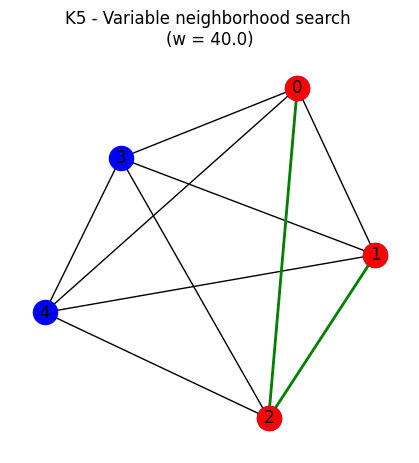

vns took 0.189164 seconds


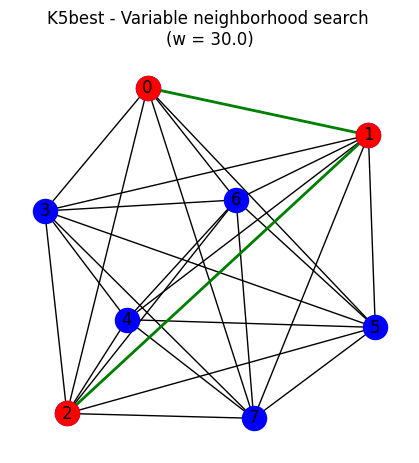

vns took 0.294373 seconds


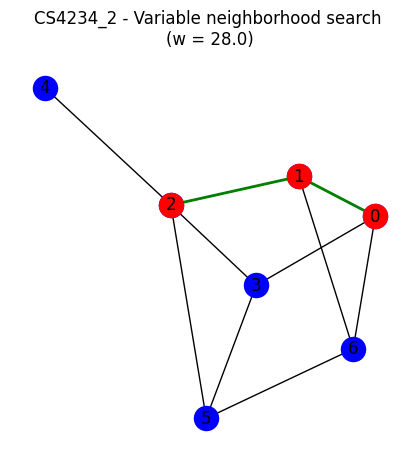

In [112]:
GS = [K5, K5best, CS4234_2]
names = ["K5", "K5best", "CS4234_2"]
terminals = [0,1,2]
for G, name in zip(GS, names): 
    pos = nx.spring_layout(G, seed = 42)
    T, w = vns(G, terminals, 100, 5)
    
    plt.figure(figsize = (4,4))
    nx.draw(G, pos, with_labels = True, node_color = 'blue')
    nx.draw_networkx_edges(T, pos, edge_color = 'green', width = 2)
    nx.draw_networkx_nodes(G, pos, nodelist = terminals, node_color = 'red')
    
   # edge_labels = nx.get_edge_attributes(G, "weight") 
   # nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 8)  

    plt.title(f"{name} - Variable neighborhood search \n(w = {w})")
    plt.show()

In [9]:
def read_stp(filename):
    G = nx.Graph()
    terminals = set()
    
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('E'):
                parts = line.split()
                u, v, w = int(parts[1]), int(parts[2]), int(parts[3])
                G.add_edge(u, v, weight = w)
            elif line.startswith('T'):
                terminals.add(int(line.split()[1]))
                
    return G, terminals

In [113]:
G, terminals = read_stp('hc6u.stp')

vns took 0.680588 seconds


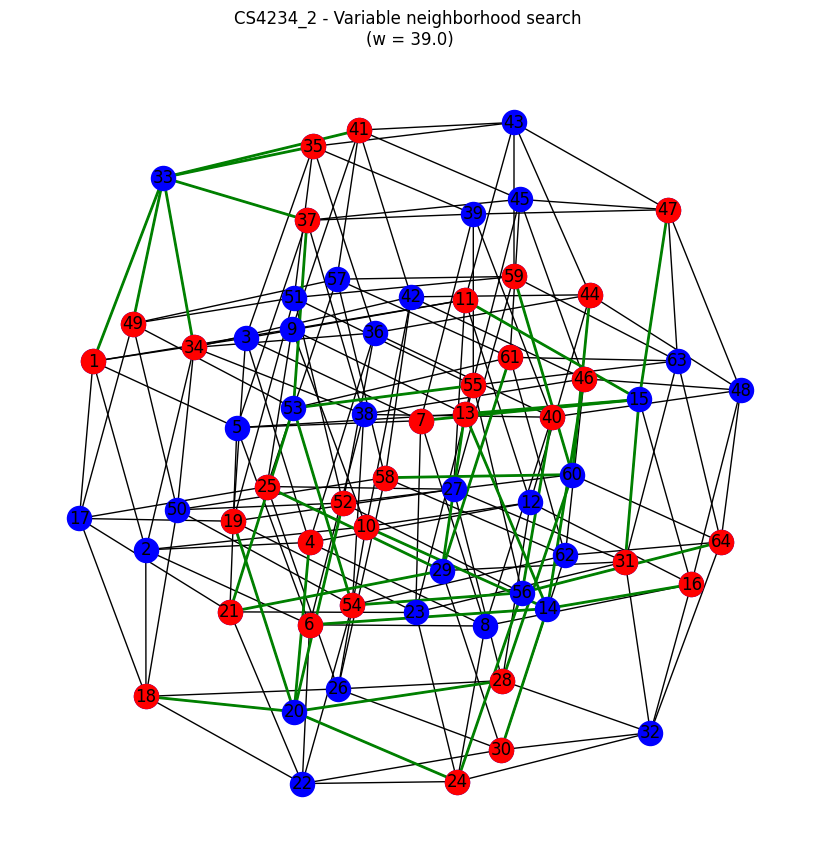

In [114]:
pos = nx.spring_layout(G, seed = 42)
T, w = vns(G, terminals, 100, 5)
    
plt.figure(figsize = (8,8))
nx.draw(G, pos, with_labels = True, node_color = 'blue')
nx.draw_networkx_edges(T, pos, edge_color = 'green', width = 2)
nx.draw_networkx_nodes(G, pos, nodelist = terminals, node_color = 'red')
    
# edge_labels = nx.get_edge_attributes(G, "weight") 
# nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 8)  

plt.title(f"{name} - Variable neighborhood search \n(w = {w})")
plt.show()

In [115]:
G, terminals = read_stp('hc12u.stp')

vns took 21917.324850 seconds


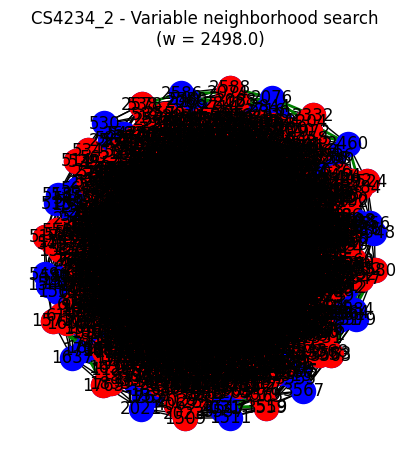

In [116]:
pos = nx.spring_layout(G, seed = 42)
T, w = vns(G, terminals, 100, 5)
    
plt.figure(figsize = (4,4))
nx.draw(G, pos, with_labels = True, node_color = 'blue')
nx.draw_networkx_edges(T, pos, edge_color = 'green', width = 2)
nx.draw_networkx_nodes(G, pos, nodelist = terminals, node_color = 'red')
    
   # edge_labels = nx.get_edge_attributes(G, "weight") 
   # nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 8)  

plt.title(f"{name} - Variable neighborhood search  \n(w = {w})")
plt.show()

In [10]:
def tests(directory):
    global df
    df = df[0:0]
    results = {}
    
    for fname in os.listdir(directory):
        if fname.endswith(".stp"):
            path = os.path.join(directory, fname)
            try:
                G, terminals = read_stp(path) 
                results[fname] = (G, terminals)
                print(f"{fname} : (Number of nodes = {G.number_of_nodes()}, number of edges = {G.number_of_edges()}, number of terminals = {len(terminals)})")
                test_big(G, terminals)
            except Exception as e:
                print(f"File error {fname}: {e}")
        print("\n")
    return 

In [11]:
def test_big(G, terminals):
    global df
    num_iterations = [10,100,1000]
    ks = [2,3,5,7]
    
    for iterations in num_iterations:
        for k in ks:
            best_tree, best_w, elapsed = vns(G, terminals, iterations, k)
            new_row = {
                "time": round(elapsed, 6),
                "nodes" : G.number_of_nodes(),
                "edges" : G.number_of_edges(),
                "best_w": best_w,
                "iterations": iterations,
                "k" : k
            }
            df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

In [14]:
tests('../Big graphs')
df

hc6p.stp : (Number of nodes = 64, number of edges = 192, number of terminals = 32)
vns took 0.842196 seconds
vns took 1.181608 seconds
vns took 1.800993 seconds
vns took 2.471650 seconds
vns took 6.953229 seconds
vns took 10.313225 seconds
vns took 16.753926 seconds
vns took 23.171927 seconds
vns took 68.356728 seconds
vns took 101.715851 seconds
vns took 167.316876 seconds
vns took 230.227193 seconds


hc6u.stp : (Number of nodes = 64, number of edges = 192, number of terminals = 32)
vns took 0.152120 seconds
vns took 0.169271 seconds
vns took 0.181627 seconds
vns took 0.221750 seconds
vns took 0.415055 seconds
vns took 0.510694 seconds
vns took 0.691369 seconds
vns took 0.822819 seconds
vns took 3.067303 seconds
vns took 4.135508 seconds
vns took 5.509134 seconds
vns took 6.504264 seconds


hc7u.stp : (Number of nodes = 128, number of edges = 448, number of terminals = 64)
vns took 0.881026 seconds
vns took 1.003884 seconds
vns took 1.055478 seconds
vns took 0.912809 seconds
vns took

,time,nodes,edges,best_w,iterations,k
0,0.842196,64,192,63.0,10,2
1,1.181608,64,192,63.0,10,3
2,1.800993,64,192,63.0,10,5
3,2.471650,64,192,63.0,10,7
4,6.953229,64,192,63.0,100,2
...,...,...,...,...,...,...
115,0.483549,64,192,32.0,100,7
116,1.562986,64,192,32.0,1000,2
117,1.998058,64,192,32.0,1000,3
118,2.725163,64,192,32.0,1000,5


In [15]:
df.to_csv('results_vns.csv')

In [16]:
sum(df["time"])

6266.681891999999

In [17]:
max(df["time"])

1045.127333